In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import plotnine as gg
import matplotlib.pyplot as plt
from poola import core as pool
import seaborn as sns
import gpplot as gpp 

In [2]:
def count_elements(seq):
    seqs = {}
    for i in seq:
        seqs[i] = seqs.get(i, 0) + 1
        
    return seqs

In [3]:
horlbeck_sept_sgrna_rc = pd.read_excel("../data/horlbeck_2016_sept/crispri_readcount.xlsx")
horlbeck_sept_sgrna_lib_comp = pd.read_excel("../data/horlbeck_2016_sept/library_comp.xlsx", sheet_name = 0)

In [4]:
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                            names=['GENE'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                   names=['GENE'])

In [5]:
all_designs = pd.read_table('../../../gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3seq-Chen2013_Ensembl_20220808.txt.gz')

In [6]:
horlbeck_sept_sgrna_lib_comp_s = horlbeck_sept_sgrna_lib_comp[['sgID', 'gene', 'protospacer sequence']]
horlbeck_sept_sgrna = pd.merge(horlbeck_sept_sgrna_lib_comp_s, horlbeck_sept_sgrna_rc, left_on = 'sgID', right_on = 'sgId')


In [7]:
# check the length of guide sequence 

len_seq = [len(seq) for seq in horlbeck_sept_sgrna['protospacer sequence']]
counted = count_elements(len_seq)
counted

{20: 209070}

In [8]:
horlbeck_sept_sgrna['protospacer sequence'].value_counts()

GTCCAGGGAAAAGGGCCAGG    4
Ggcctggctacggttggtag    4
GAGGGTCGCGAGGGCTGTGG    4
GGAGGCGAGGCCGCCAGTCG    4
GGTTCTCAAAGGAACAACTA    4
                       ..
GCTTAAAGGCGCCCGAGTGT    1
GTTGAGGGAGCCCTCCGATG    1
GCTGACGGCCGGAAGGAAAA    1
GAGGGGTCTGCCCCATCGGA    1
GAGAAGCCAACCTCGCGTTA    1
Name: protospacer sequence, Length: 205656, dtype: int64

In [9]:
unfiltered_duplicate_sgrna = horlbeck_sept_sgrna[horlbeck_sept_sgrna.duplicated('protospacer sequence', keep=False) == True]


# Rep correlation 

In [10]:
lognorms = pool.lognorm_columns(reads_df=horlbeck_sept_sgrna, columns=['T0, Rep1, rc', 'Endpoint, Rep1, rc', 'T0, Rep2, rc', 'Endpoint, Rep2, rc'])
lfc_df = pool.calculate_lfcs(lognorm_df=lognorms, ref_col='T0, Rep1, rc', target_cols=['Endpoint, Rep1, rc'])
lfc_df = pool.calculate_lfcs(lognorm_df=lfc_df, ref_col='T0, Rep2, rc', target_cols=['Endpoint, Rep2, rc'])

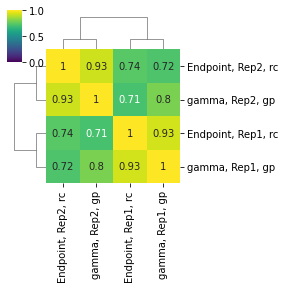

In [11]:
sns.clustermap(lfc_df[[
 'Endpoint, Rep1, rc',
 'Endpoint, Rep2, rc',
 'gamma, Rep1, gp',
'gamma, Rep2, gp']].corr(), vmin= 0, cmap= 'viridis', annot= True, figsize= (4,4))
gpp.savefig('../figure/horlbeck_sept_rep_corr.pdf', dpi=300)

# ROC-AUC

In [12]:
avg_replicate_lfc_df_condition_map = pool.average_replicate_lfcs(lfcs=lfc_df[['protospacer sequence', 'Endpoint, Rep1, rc', 'Endpoint, Rep2, rc', 
                                                                              'gamma, Rep1, gp', 'gamma, Rep2, gp', 'gamma, ave_Rep1_Rep2, gp']], guide_col='protospacer sequence',
                                                            condition_map={'Endpoint, Rep1, rc': 'Endpoint',
                                                                           'Endpoint, Rep2, rc': 'Endpoint'})

In [13]:
avg_replicate_lfc_df_condition_map = pd.merge(avg_replicate_lfc_df_condition_map, 
                                              lfc_df[['protospacer sequence','gene', 'gamma, ave_Rep1_Rep2, gp']], 
                                              on ='protospacer sequence')

In [14]:
lfcs_designs = (avg_replicate_lfc_df_condition_map.rename({'protospacer sequence': 'sgRNA Sequence',
                                                          'gene': 'Target Gene Symbol'}, axis = 1)
                .merge(all_designs, how = 'inner', on = ['sgRNA Sequence','Target Gene Symbol']))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs.sort_values('ROC-AUC')

,condition,ROC-AUC
0,Endpoint,0.858284


# Compare different normalization techniques

In [15]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()



In [16]:
filtered_sgs['sgRNA Context Sequence'].value_counts()

GCGGGAAAAGGCTGCCGCTCTGGGAGGAGG    1
TGGCGGCGGCCAGAGCTACTACGCCGGCCG    1
ACTGGGCGGAGACGGGAGCCACGCCGGGTA    1
CGGGGGCGGAGCTCCGGCGCATCATGGCGG    1
CCCGGGCGGAGGACTCCCGTGAGGGGGAAC    1
                                 ..
TTGGGCGCAGACCTTGGTCGTCCCCGGCGG    1
CAGCGCGCAGCAAGCGAGGCGCGTGGGCGC    1
CGTAGCGCAGCACTTTCTCCCCCGTGGCCT    1
AGAAGCGCAGCAGAAAGGCGTCCGGGGACC    1
TGTAGTTTGTAGCGGACAACATGGCGGCCT    1
Name: sgRNA Context Sequence, Length: 3257, dtype: int64

In [17]:
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                             .avg_lfc
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                               .avg_lfc
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                        .avg_lfc
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score', 'sgRNA \'Cut\' Site TSS Offset',
                                     'DHS Score','Off-Target Rank','Pick Order'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_lfc = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_lfc = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_lfc = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_lfc = ('gene_robust_zscore', 'mean'),
                    avg_lfc = ('avg_lfc', 'mean'))
               .reset_index())

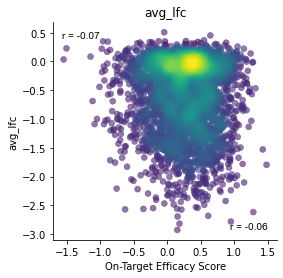

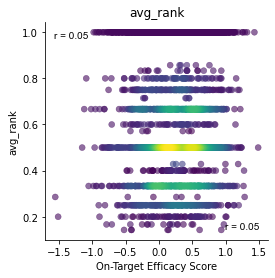

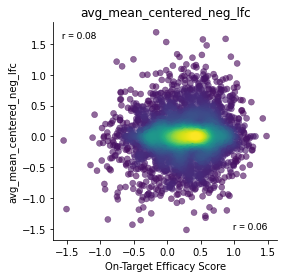

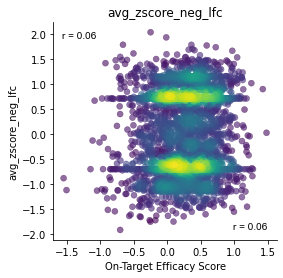

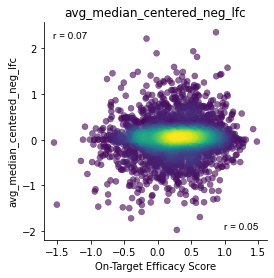

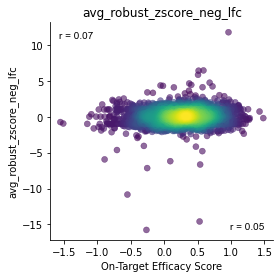

In [18]:
for score in ['avg_lfc','avg_rank', 'avg_mean_centered_neg_lfc', 'avg_zscore_neg_lfc',
              'avg_median_centered_neg_lfc', 'avg_robust_zscore_neg_lfc']:
    plt.subplots(figsize=(4,4))
    gpp.point_densityplot(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                             y=score, x='On-Target Efficacy Score')
    gpp.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score')
    gpp.add_correlation(data=sg_avg_rank[[score, 'On-Target Efficacy Score']].dropna(),
                           y=score, x='On-Target Efficacy Score', method='spearman', loc='lower right')
    plt.title(score)
    sns.despine()

In [19]:
sg_avg_rank

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,On-Target Efficacy Score,sgRNA 'Cut' Site TSS Offset,DHS Score,Off-Target Rank,Pick Order,avg_rank,avg_mean_centered_neg_lfc,avg_zscore_neg_lfc,avg_median_centered_neg_lfc,avg_robust_zscore_neg_lfc,avg_lfc
0,GAAAAGGCTGCCGCTCTGGG,GCGGGAAAAGGCTGCCGCTCTGGGAGGAGG,COPS3,-0.11700,0,1.0,50,25.0,0.750000,0.033173,0.203717,0.037973,0.245310,-0.454623
1,GAAAATAGGGCGCCGGAAGT,GTGAGAAAATAGGGCGCCGGAAGTCGGCTT,C18orf21,0.13720,-10,1.0,5,24.0,1.000000,0.026221,0.859323,0.018950,0.634685,-0.187906
2,GAAACCGCGGCGATACTGGG,TGTAGAAACCGCGGCGATACTGGGAGGAAG,WDR46,0.17740,229,1.0,43,10.0,1.000000,0.075586,0.707107,0.075586,1.000000,-1.432060
3,GAAACCTTGGACACAGTTCT,TGAGGAAACCTTGGACACAGTTCTGGGTAC,NKAP,-0.11040,13,1.0,16,23.0,1.000000,0.098937,0.707107,0.098937,1.000000,-1.306050
4,GAAACGCACAGCAACTCGCA,CAGAGAAACGCACAGCAACTCGCATGGAGG,DHX9,0.15150,23,1.0,16,4.0,1.000000,0.042397,0.707107,0.042397,1.000000,-0.580343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,GTTGTTGGACGAAGTCGCTC,AGTCGTTGTTGGACGAAGTCGCTCTGGAGG,GTF3C1,0.63950,43,0.0,3,1.0,0.333333,-0.136045,-1.003657,-0.137042,-1.011031,-0.163662
3182,GTTTACGCACCGACACCGGG,GGGGGTTTACGCACCGACACCGGGTGGCCA,GART,0.02132,41,1.0,10,2.0,0.666667,-0.049382,-0.060485,0.000000,0.000000,-1.595348
3183,GTTTCGCGAGCGCGTTGGAG,GGCGGTTTCGCGAGCGCGTTGGAGCGGCAC,MRPS28,0.18340,177,1.0,45,16.0,0.750000,0.094691,0.134231,0.295246,0.358623,-0.681182
3184,GTTTCTCAGGGAGAGAGCGG,TCTTGTTTCTCAGGGAGAGAGCGGAGGTGT,BRD8,0.58670,233,1.0,43,7.0,0.500000,-0.200013,-0.567372,-0.160511,-0.365449,-0.055527


In [23]:
lfcs_designs.to_csv('../data/horlbeck_2016_sept/horlbeck2016_condition_lfcs.csv', index=False)
sg_avg_rank.to_csv('../data/horlbeck_2016_sept/horlbeck2016_sept_activity.csv', index=False)

# Compare LFCs, gamma, normalized LFCs

In [ ]:
relevant_sgs_designs = lfcs_designs
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                             .avg_lfc
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                               .avg_lfc
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                        .avg_lfc
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])
                                      .avg_lfc
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_lfc = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_lfc = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_lfc = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_lfc = ('gene_robust_zscore', 'mean'),
                    avg_lfc = ('avg_lfc', 'mean'))
               .reset_index())

In [ ]:
relevant_sgs_designs = lfcs_designs
filtered_sgs = relevant_sgs_designs[relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0'].copy()
filtered_sgs['gene_mean_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['gamma, ave_Rep1_Rep2, gp']
                                      .transform(lambda x: -(x - x.mean())))
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['gamma, ave_Rep1_Rep2, gp']
                             .rank(pct=True, ascending=False))

filtered_sgs['gene_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['gamma, ave_Rep1_Rep2, gp']
                               .transform(lambda x: -(x - x.mean())/x.std()))
filtered_sgs['gene_median_centered'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['gamma, ave_Rep1_Rep2, gp']
                                        .transform(lambda x: -(x - x.median())))
filtered_sgs['gene_robust_zscore'] = (filtered_sgs.groupby(['Target Gene Symbol', 'condition'])['gamma, ave_Rep1_Rep2, gp']
                                      .transform(lambda x: -(x - x.median())/(x.quantile(0.75) - x.quantile(0.25))))

sg_avg_rank_gamma = (filtered_sgs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                                      'On-Target Efficacy Score'])
               .agg(avg_rank = ('gene_rank', 'mean'),
                    avg_mean_centered_neg_gamma = ('gene_mean_centered', 'mean'),
                    avg_zscore_neg_gamma = ('gene_zscore', 'mean'),
                    avg_median_centered_neg_gamma = ('gene_median_centered', 'mean'),
                    avg_robust_zscore_neg_gamma = ('gene_robust_zscore', 'mean'),
                    avg_gamma = ('gamma, ave_Rep1_Rep2, gp', 'mean'))
               .reset_index())

In [ ]:
sg_avg = pd.merge(sg_avg_rank, sg_avg_rank_gamma, on = ['sgRNA Sequence',
 'sgRNA Context Sequence',
 'Target Gene Symbol',
 'On-Target Efficacy Score'])

In [ ]:
sns.clustermap(sg_avg[[
 'avg_mean_centered_neg_lfc',
 'avg_lfc',
 'On-Target Efficacy Score',
 'avg_gamma',
    'avg_mean_centered_neg_gamma'
]].corr(), vmin= 0, cmap= 'viridis', annot= True, figsize= (10,10))
gpp.savefig('../figure/horlbeck_sept_lfcnorm_gamma_corr.pdf', dpi=300)

In [ ]:
len(sg_avg)

In [ ]:
fig = sns.kdeplot(sg_avg['avg_gamma'], shade=True, color="r")
fig = sns.kdeplot(sg_avg['avg_lfc'], shade=True, color="b")
fig = sns.kdeplot(sg_avg['avg_mean_centered_neg_gamma'], shade=True, color="y")
fig = sns.kdeplot(sg_avg['avg_mean_centered_neg_lfc'], shade=True, color="g")
plt.show()

In [ ]:

df = pd.DataFrame(data = sg_avg, columns = ['avg_gamma', 'avg_mean_centered_neg_gamma','avg_mean_centered_neg_lfc','avg_lfc'])
df.boxplot()

# Compare LFCs, gamma, Activity score, average mean centered negtive 

In [ ]:
horlbeck_may = pd.read_excel("../data/horlbeck_2016_may/elife-12677-supp1-v4.xlsx", sheet_name = 0)

In [ ]:
act_gamma = pd.merge(horlbeck_may.rename({'sgRNA sequence': 'sgRNA Sequence'}, axis = 1), sg_avg, on = 'sgRNA Sequence')

In [ ]:
len(act_gamma)

In [ ]:
sns.clustermap(act_gamma[['Activity score',
 'avg_lfc',
 'avg_gamma',
          'avg_mean_centered_neg_lfc',
          'On-Target Efficacy Score']].corr(), vmin= 0, cmap= 'viridis', annot= True, figsize= (10,10))
gpp.savefig('../figure/horlbeck_sept_pheno_rs3_corr.pdf', dpi=300)

In [ ]:
gamma_lfc = pd.merge(sg_avg_rank, lfc_df.rename({'protospacer sequence': 'sgRNA Sequence'}, axis = 1), on = 'sgRNA Sequence')

In [ ]:

gpp.point_densityplot(data=gamma_lfc.dropna(),
                             y='avg_mean_centered_neg_lfc', x='gamma, ave_Rep1_Rep2, gp')
gpp.add_correlation(data=gamma_lfc.dropna(),
                           y='avg_mean_centered_neg_lfc', x='gamma, ave_Rep1_Rep2, gp')
gpp.add_correlation(data=gamma_lfc.dropna(),
                           y='avg_mean_centered_neg_lfc', x='gamma, ave_Rep1_Rep2, gp', method='spearman', loc='lower right')

In [ ]:
gpp.point_densityplot(data=gamma_lfc.dropna(),
                             y='avg_lfc', x='gamma, ave_Rep1_Rep2, gp')
gpp.add_correlation(data=gamma_lfc.dropna(),
                           y='avg_lfc', x='gamma, ave_Rep1_Rep2, gp')
gpp.add_correlation(data=gamma_lfc.dropna(),
                           y='avg_lfc', x='gamma, ave_Rep1_Rep2, gp', method='spearman', loc='lower right')